- Binary influence
- HR influence
- HRV influnce
- Load Leipzig corpora
- Translate Leipzig corpora from EN to FR and ES base on the influence
- Evaluate translation based on the influence
- Compare evaluation with original signal
- Summarize for thesis

#### Prep

In [14]:
!pip install SentencePiece
!pip install sacremoses

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 6.5 MB/s eta 0:00:00


In [9]:
!pip install tqdm

#### Binary Influence

In [1]:
import random

def generate_random_binary_array(length):
    return [random.randint(0, 1) for _ in range(length)]

# Generate an array of 10 binary numbers, each being a sequence of 5 bits
binary_array = generate_random_binary_array(10)
print(binary_array)


[1, 0, 0, 1, 1, 1, 0, 0, 0, 1]


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Load Leipzig Corpora and add influence

In [6]:
import re
import pandas as pd
import numpy as np


file_path = '/content/drive/My Drive/Colab Notebooks/eng_news_2020_10K-sentences.txt'

data = []
with open(file_path, 'r') as file:
    for line in file:
        line = re.sub(r"^(\d+)\s", r"\1\t", line)
        data.append(line.strip().split('\t'))

df = pd.DataFrame(data)
df = df.iloc[0:1000]
df.columns = ['id', 'en_sentence']
df['influence'] = generate_random_binary_array(1000)
df['influence_lang'] = np.where(df['influence'] == 1, 'fr', 'es')

df


,id,en_sentence,influence,influence_lang
0,1,"“18 months ago, we expelled a boy at Nations f...",1,fr
1,2,” 41 Nigeria Centre for Disease Control (NCDC)...,1,fr
2,3,⏰8.00pm ⚽️Liverpool v Arsenal Watch the match ...,0,es
3,4,"A 13-year veteran of the department, he worked...",0,es
4,5,A 1975 class ring from Robert E. Lee High Scho...,1,fr
...,...,...,...,...
995,996,"“Authentic and honest, she taught us the impor...",0,es
996,997,Authorities described Williams as a predatory ...,1,fr
997,998,"Authorities in Argentina, Chile and Brazil pla...",0,es
998,999,Authorities in northeast Spain have ordered th...,0,es


In [8]:
from transformers import MarianMTModel, MarianTokenizer

def translate(text, src_lang, tgt_lang):
    # Define the model name
    model_name = f'Helsinki-NLP/opus-mt-{src_lang}-{tgt_lang}'

    # Load tokenizer and model from pretrained MarianMT
    tokenizer = MarianTokenizer.from_pretrained(model_name)
    model = MarianMTModel.from_pretrained(model_name)

    # Tokenize the text
    translated = model.generate(**tokenizer(text, return_tensors="pt", padding=True))

    # Decode the translated text
    translated_text = tokenizer.decode(translated[0], skip_special_tokens=True)

    return translated_text

# Example usage
source_text = "Hello, world!"
source_language = "en"  # English
target_language = "fr"  # French

translated_text = translate(source_text, source_language, target_language)
print(f"Translated text: {translated_text}")

Translated text: Bonjour, le monde!


In [10]:
from tqdm import tqdm
tqdm.pandas()

src_lang = 'en'

df['influenced_sentence'] = df.progress_apply(lambda row: translate(row['en_sentence'], src_lang, row['influence_lang']), axis=1)


100%|██████████| 1000/1000 [1:33:25<00:00,  5.61s/it]


In [11]:
df

,id,en_sentence,influence,influence_lang,influenced_sentence
0,1,"“18 months ago, we expelled a boy at Nations f...",1,fr,"Il y a 18 mois, nous avons expulsé un garçon d..."
1,2,” 41 Nigeria Centre for Disease Control (NCDC)...,1,fr,41 membres du personnel du Centre nigérian de ...
2,3,⏰8.00pm ⚽️Liverpool v Arsenal Watch the match ...,0,es,¡Mira el partido en vivo en The Arch en seis p...
3,4,"A 13-year veteran of the department, he worked...",0,es,"Un veterano de 13 años del departamento, traba..."
4,5,A 1975 class ring from Robert E. Lee High Scho...,1,fr,Un anneau de classe 1975 de l'école secondaire...
...,...,...,...,...,...
995,996,"“Authentic and honest, she taught us the impor...",0,es,"Auténtica y honesta, nos enseñó la importancia..."
996,997,Authorities described Williams as a predatory ...,1,fr,Les autorités ont décrit Williams comme un esc...
997,998,"Authorities in Argentina, Chile and Brazil pla...",0,es,"Las autoridades de Argentina, Chile y Brasil p..."
998,999,Authorities in northeast Spain have ordered th...,0,es,Las autoridades del noreste de España han orde...


In [12]:
file_path_csv = '/content/drive/My Drive/Colab Notebooks/01_text_translation.csv'

df.to_csv(file_path_csv, index=False)

In [1]:
!pip install fasttext-langdetect

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 kB 1.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached pybind11-2.11.1-py3-none-any.whl (227 kB)
  Created wheel for fasttext-langdetect: filename=fasttext_langdetect-1.0.5-py3-none-any.whl size=7502 sha256=c63c94a112431ff4d919d36114afd55b2fbd5e43c1f25e587fe43ba531796264
  Stored in directory: /root/.cache/pip/wheels/e6/5b/5d/47e2fd5c2ff1028722739ce35f365e8f6eeb89ec97aa63e621
  Created wheel for fasttext: filename=fasttext-0.9.2-cp310-cp310-linux_x86_64.whl size=4199773 sha256=984f710917b3e35fa1456f11aa53a5bd82f64de312b6c13cc43636d9bf641b0d
  Stored in directory: /root/.cache/pip/wheels/a5/13/75/f811c84a8ab36eedbaef977a6a58a98990e8e0f1967f98f394
Successfully built fasttext-langdetect fasttext


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd

file_path_csv = '/content/drive/My Drive/Colab Notebooks/01_text_translation.csv'
df = pd.read_csv(file_path_csv)

In [5]:
df.head()

,id,en_sentence,influence,influence_lang,influenced_sentence
0,1,"“18 months ago, we expelled a boy at Nations f...",1,fr,"Il y a 18 mois, nous avons expulsé un garçon d..."
1,2,” 41 Nigeria Centre for Disease Control (NCDC)...,1,fr,41 membres du personnel du Centre nigérian de ...
2,3,⏰8.00pm ⚽️Liverpool v Arsenal Watch the match ...,0,es,¡Mira el partido en vivo en The Arch en seis p...
3,4,"A 13-year veteran of the department, he worked...",0,es,"Un veterano de 13 años del departamento, traba..."
4,5,A 1975 class ring from Robert E. Lee High Scho...,1,fr,Un anneau de classe 1975 de l'école secondaire...


In [7]:
from tqdm import tqdm
tqdm.pandas()

from ftlangdetect import detect

# Apply function with progress bar
df[['detected_lang', 'detected_lang_score']] = df['influenced_sentence'].progress_apply(
    lambda text: pd.Series(detect(text))
)


100%|██████████| 1000/1000 [00:02<00:00, 359.13it/s]


In [8]:
df.head()

,id,en_sentence,influence,influence_lang,influenced_sentence,detected_lang,detected_lang_score
0,1,"“18 months ago, we expelled a boy at Nations f...",1,fr,"Il y a 18 mois, nous avons expulsé un garçon d...",fr,0.993772
1,2,” 41 Nigeria Centre for Disease Control (NCDC)...,1,fr,41 membres du personnel du Centre nigérian de ...,fr,0.988928
2,3,⏰8.00pm ⚽️Liverpool v Arsenal Watch the match ...,0,es,¡Mira el partido en vivo en The Arch en seis p...,es,0.977360
3,4,"A 13-year veteran of the department, he worked...",0,es,"Un veterano de 13 años del departamento, traba...",es,0.976541
4,5,A 1975 class ring from Robert E. Lee High Scho...,1,fr,Un anneau de classe 1975 de l'école secondaire...,fr,0.993495


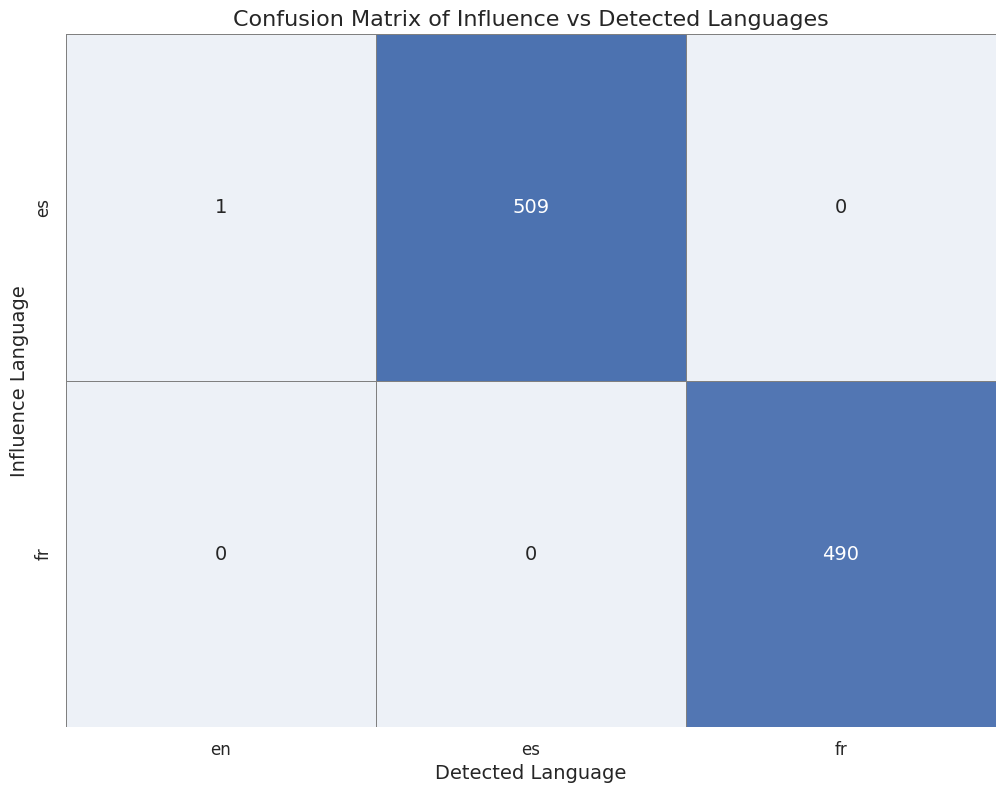

In [70]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors

img_path = '/content/drive/My Drive/Colab Notebooks/'

# Create a confusion matrix
confusion_matrix = pd.crosstab(df['influence_lang'], df['detected_lang'])

# Define your list of colors
colors = ["#edf1f7", "#4c72b0"]  # Replace with your colors
# Create a custom colormap
cmap = mcolors.LinearSegmentedColormap.from_list("my_cmap", colors)

# Plot the matrix
plt.figure(figsize=(12, 9))  # Larger figure size
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap = cmap, linewidths=0.5, linecolor='gray', cbar=False, annot_kws={"size": 14})


plt.title('Confusion Matrix of Influence vs Detected Languages', fontsize=16)
plt.xlabel('Detected Language', fontsize=14)
plt.ylabel('Influence Language', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)


# Saving the figure
plt.savefig(img_path + 'translation_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

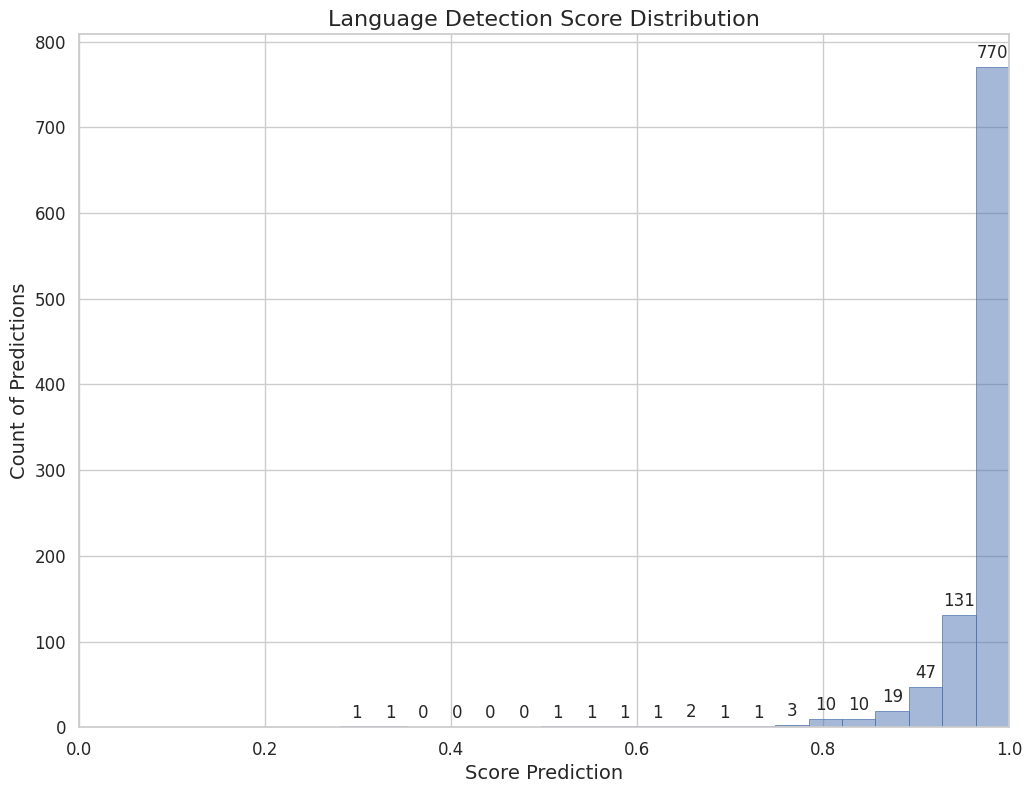

In [71]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set style for seaborn
# sns.set(style="whitegrid")

# Assuming 'df' is your DataFrame and 'score' is the column with the score prediction
plt.figure(figsize=(12, 9))

# Create histogram with density=False to show counts and not density
# ax = sns.histplot(df['detected_lang_score'], bins=30, kde=False, color='skyblue', alpha=0.5)
ax = sns.histplot(df['detected_lang_score'], bins=20, kde=False, color='#4c72b0', alpha=0.5, edgecolor='#4c72b0', linewidth=0.5)


# Annotate counts above bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

plt.title('Language Detection Score Distribution', fontsize=16)
plt.xlabel('Score Prediction', fontsize=14)
plt.ylabel('Count of Predictions', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim(0, 1)  # Assuming the score ranges from 0 to 1

plt.savefig(img_path + 'translation_score_distribution.png', dpi=300, bbox_inches='tight')
plt.show()


['#4c72b0', '#dd8452', '#55a868', '#c44e52', '#8172b3', '#937860', '#da8bc3', '#8c8c8c', '#ccb974', '#64b5cd']


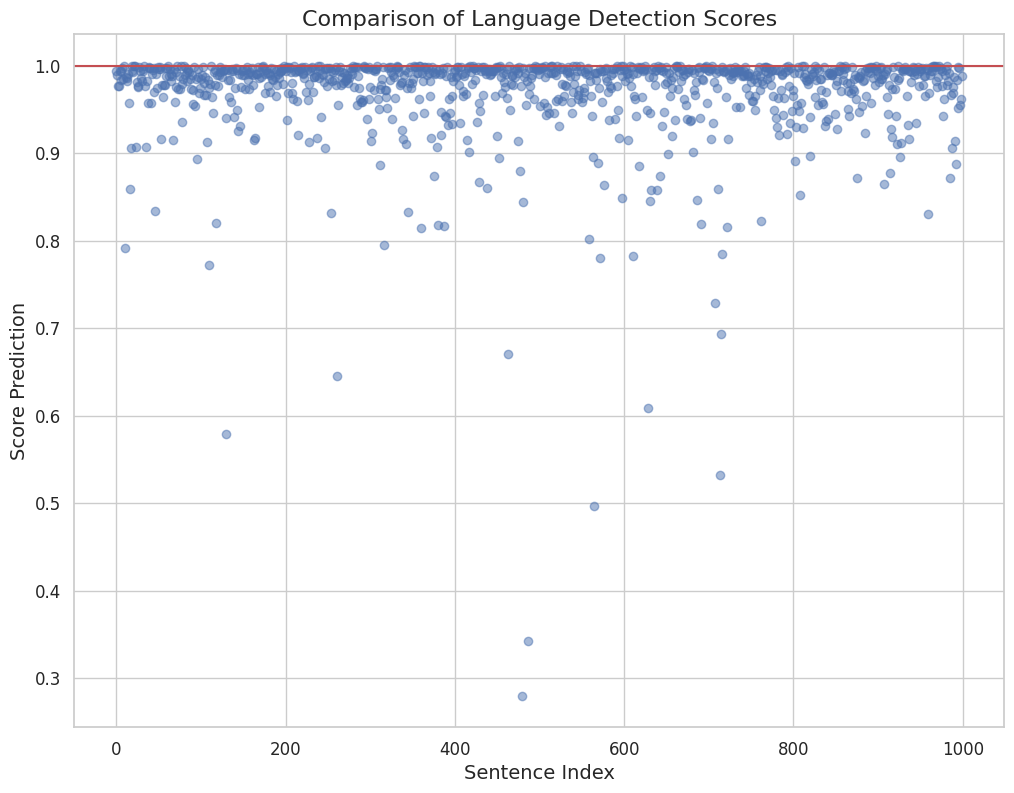

In [72]:
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame and 'score' is the column with the score prediction
plt.figure(figsize=(12, 9))
plt.scatter(df.index, df['detected_lang_score'], alpha=0.5, label='Detected Language Score')
plt.axhline(y=1, color='r', linestyle='-', label='Constant Score of 1')

plt.title('Comparison of Language Detection Scores',  fontsize=16)
plt.xlabel('Sentence Index', fontsize=14)
plt.ylabel('Score Prediction', fontsize=14)
# plt.legend()
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.savefig(img_path + 'translation_scatter_plot.png', dpi=300, bbox_inches='tight')

current_palette = sns.color_palette()
print(current_palette.as_hex())
plt.show()

In [73]:
df[df['detected_lang'] == 'en']

,id,en_sentence,influence,influence_lang,influenced_sentence,detected_lang,detected_lang_score
707,708,"Arnie-His Army — Golf Channel, 8 p.m.",0,es,"Arnie-His Army — Golf Channel, 20.00 horas",en,0.729282


In [75]:
count = (df['detected_lang_score'] >= 0.9).sum()
count

942